#1. CNN thường

## Introduction

_Depth estimation_ is a crucial step towards inferring scene geometry from 2D images.
The goal in _monocular depth estimation_ is to predict the depth value of each pixel or
inferring depth information, given only a single RGB image as input.
This example will show an approach to build a depth estimation model with a convnet
and simple loss functions.

![depth](https://paperswithcode.com/media/thumbnails/task/task-0000000605-d9849a91.jpg)

## Setup

In [ ]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

## Downloading the dataset

We will be using the dataset **DIODE: A Dense Indoor and Outdoor Depth Dataset**  for this
tutorial. However, we use the validation set generating training and evaluation subsets
for our model. The reason we use the validation set rather than the training set of the original dataset is because
the training set consists of 81GB of data, which is challenging to download compared
to the validation set which is only 2.6GB.
Other datasets that you could use are
**[NYU-v2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)**
and **[KITTI](http://www.cvlibs.net/datasets/kitti/)**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Thị giác máy tính/Đồ án

/content/drive/MyDrive/Thị giác máy tính/Đồ án


## Chuẩn bị data
Sử dụng data indoor để train

In [ ]:
path = "/content/drive/MyDrive/Thị giác máy tính/Đồ án/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

## data
RGB images (*.png): RGB images with a resolution of 1024 × 768.

Depth maps (*_depth.npy): Depth ground truth with the same resolution as the images.

Depth masks (*_depth_mask.npy): Binary depth validity masks where 1 indicates valid sensor returns and 0 otherwise.

In [ ]:
df

,image,depth,mask
234,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
110,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
248,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
9,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
93,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
...,...,...,...
188,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
71,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
106,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...
270,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...,/content/drive/MyDrive/Thị giác máy tính/Đ...


In [ ]:
df['depth'].head()

234    /content/drive/MyDrive/Thị giác máy tính/Đ...
110    /content/drive/MyDrive/Thị giác máy tính/Đ...
248    /content/drive/MyDrive/Thị giác máy tính/Đ...
9      /content/drive/MyDrive/Thị giác máy tính/Đ...
93     /content/drive/MyDrive/Thị giác máy tính/Đ...
Name: depth, dtype: object

In [ ]:
df['image'].shape[0]

325

In [ ]:
df['depth'].shape[0]

325

In [ ]:
df['mask'].shape[0]

325

In [ ]:
df.index.tolist

<bound method IndexOpsMixin.tolist of Int64Index([234, 110, 248,   9,  93, 219, 287, 198, 203, 101,
            ...
             87, 214, 121, 324,  20, 188,  71, 106, 270, 102],
           dtype='int64', length=325)>

## Các tham số

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 32

## Building a data pipeline

1. Đường ống lấy khung dữ liệu chứa đường dẫn cho hình ảnh RGB, cũng như các tệp mặt nạ chiều sâu và độ sâu.
2. Nó đọc và thay đổi kích thước hình ảnh RGB.
3. Nó đọc các tệp mặt nạ độ sâu và độ sâu, xử lý chúng để tạo ra hình ảnh bản đồ độ sâu và thay đổi kích thước của nó
4. Nó trả về hình ảnh RGB và hình ảnh bản đồ độ sâu cho một loạt.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        self truy cập các thuộc tính của lớp
        """
        self.data = data
        self.indices = self.data.index.tolist() # danh sách các index
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size # Số lượng mẫu trong 1 lần huấn luyện
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size)) # tính số lần lấy data để train qua 1 epoch

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        cập nhật lại sau mỗi lần xog epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image.
        Tải đầu vào và hình ảnh mục tiêu"""

        image_ = cv2.imread(image_path) # đọc ảnh 
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB) #chuẩn hóa hình ảnh về RGB
        image_ = cv2.resize(image_, self.dim) # chuẩn hóa kích thước về dim(768, 1024)
        image_ = tf.image.convert_image_dtype(image_, tf.float32) # chuyển đổi sang dtype

        depth_map = np.load(depth_map).squeeze() # loại bỏ độ sâu lớn hơn 1 (không rõ)

        mask = np.load(mask)
        mask = mask > 0 # độ sâu lớn hơn 0

        max_depth = min(300, np.percentile(depth_map, 99)) # chia dộ sâu theo phần trăm rồi lấy min
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

## Visualizing samples

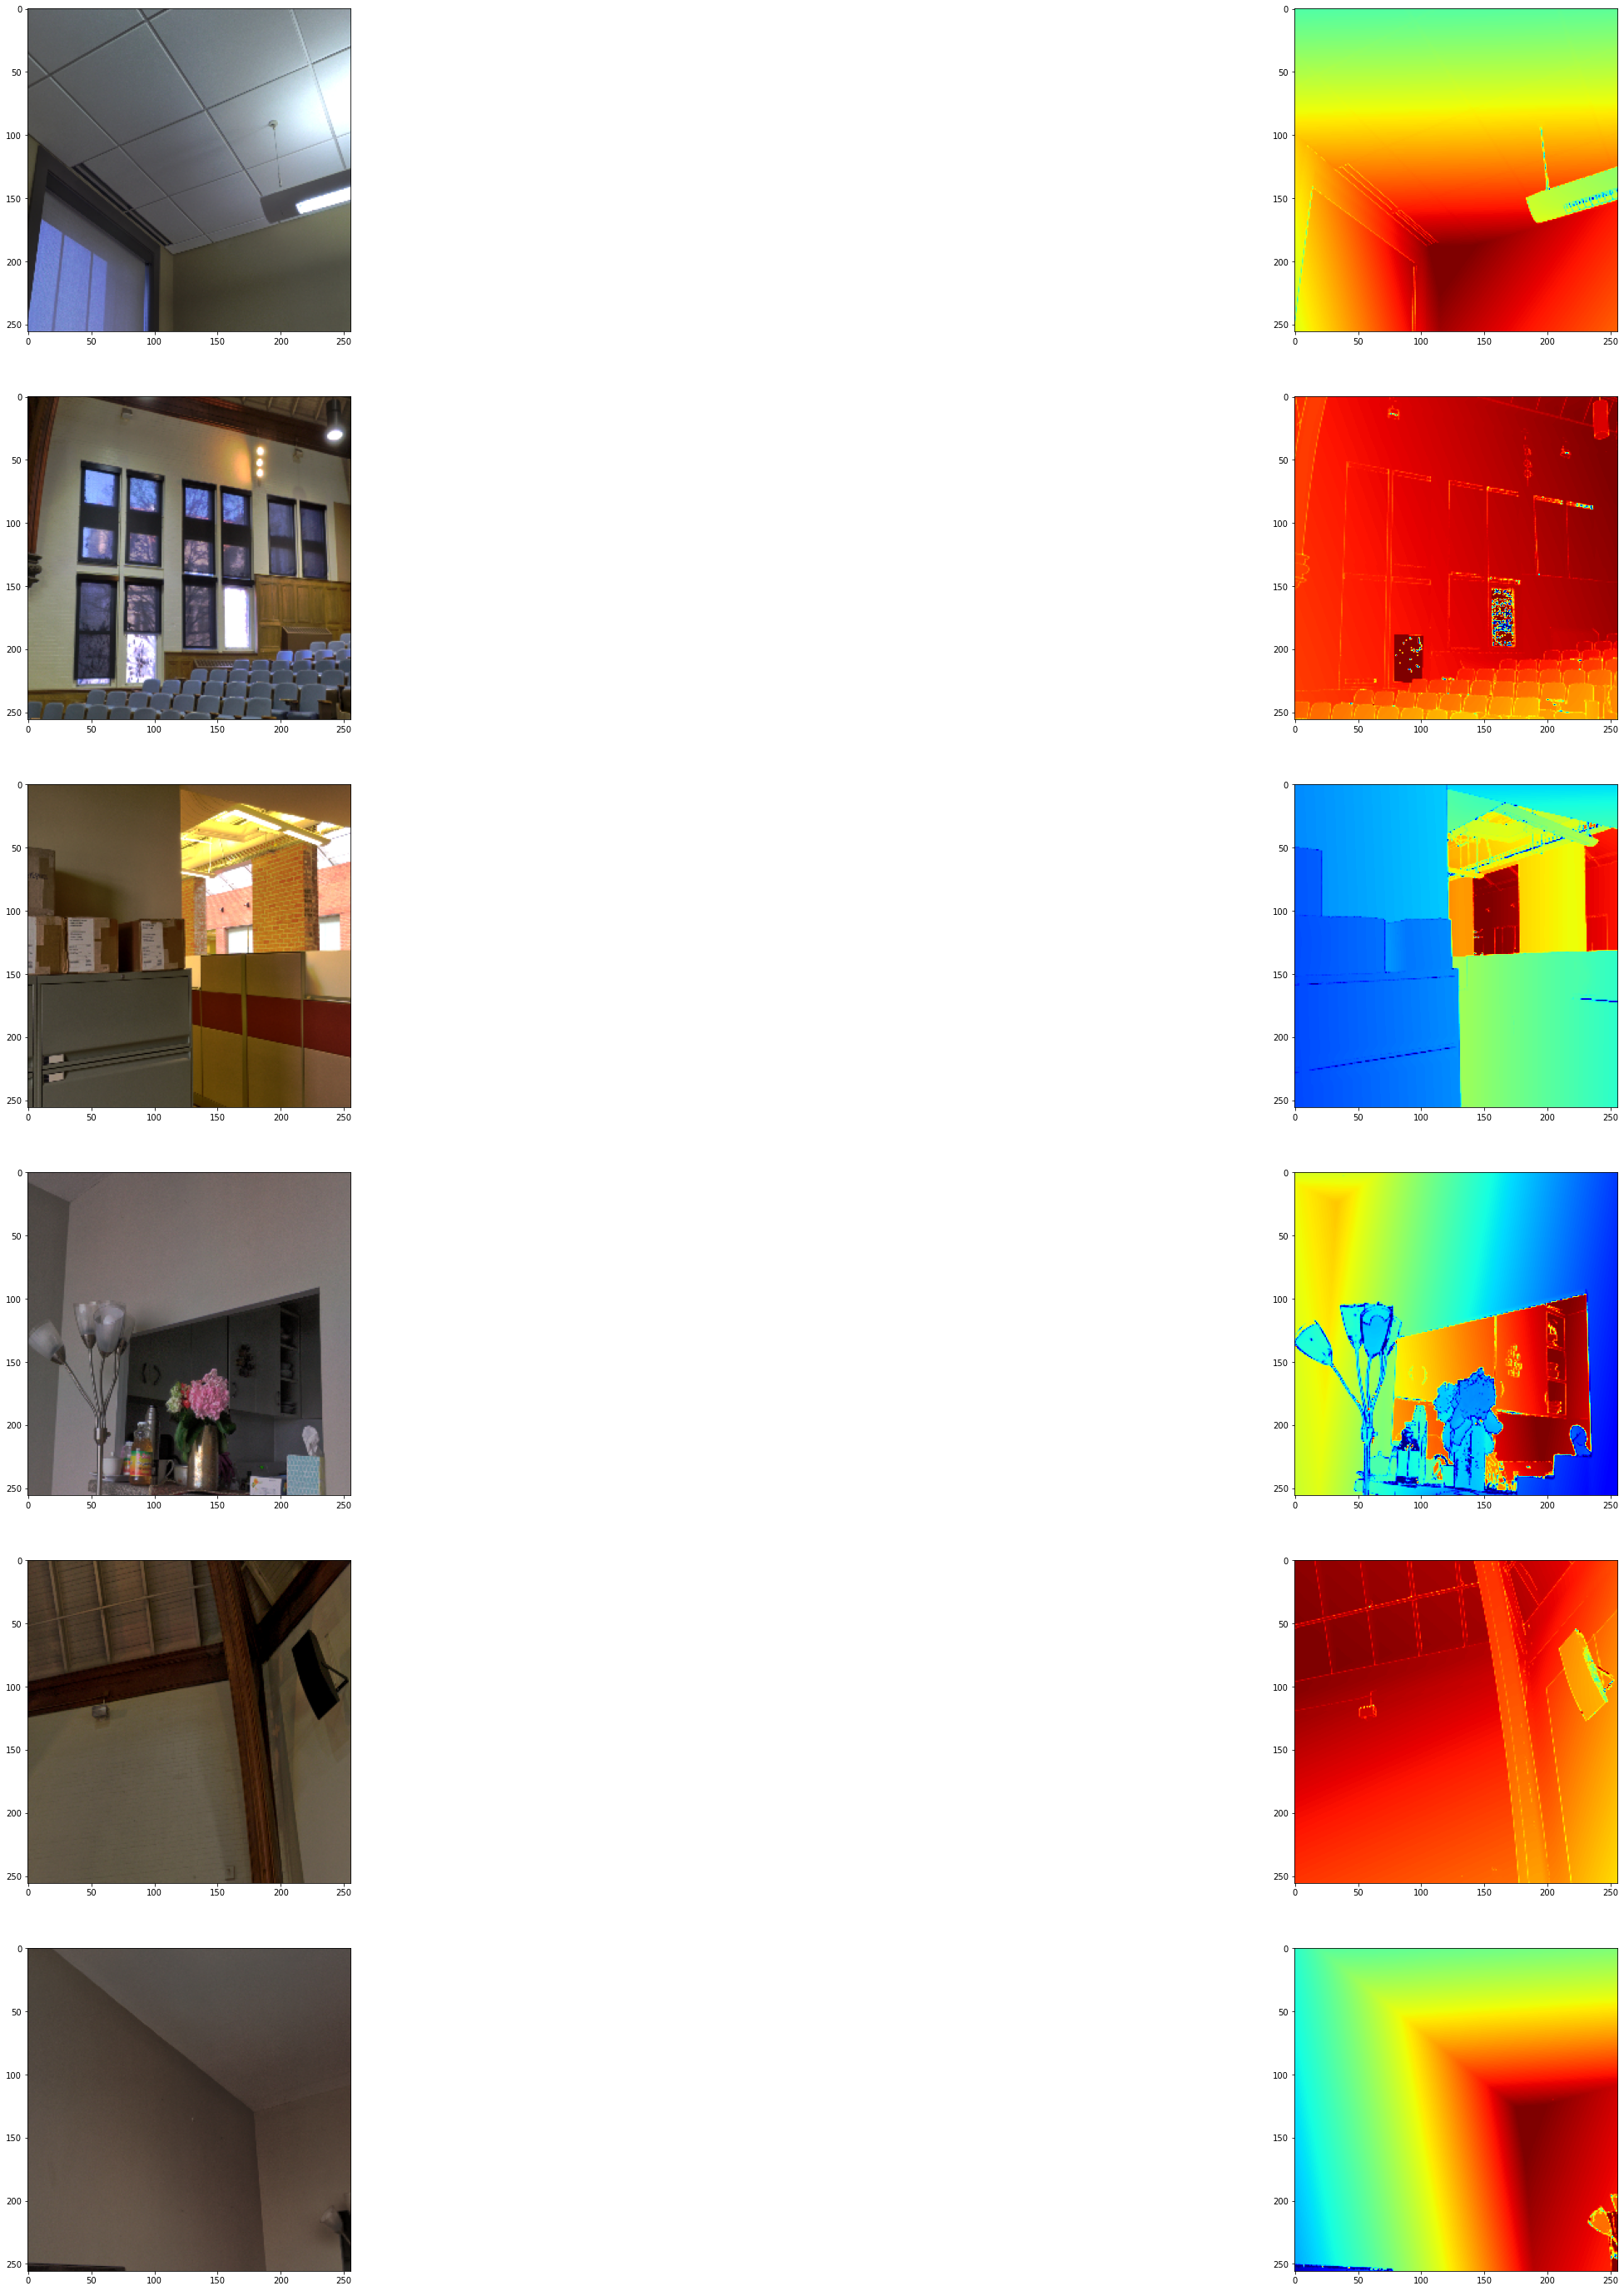

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

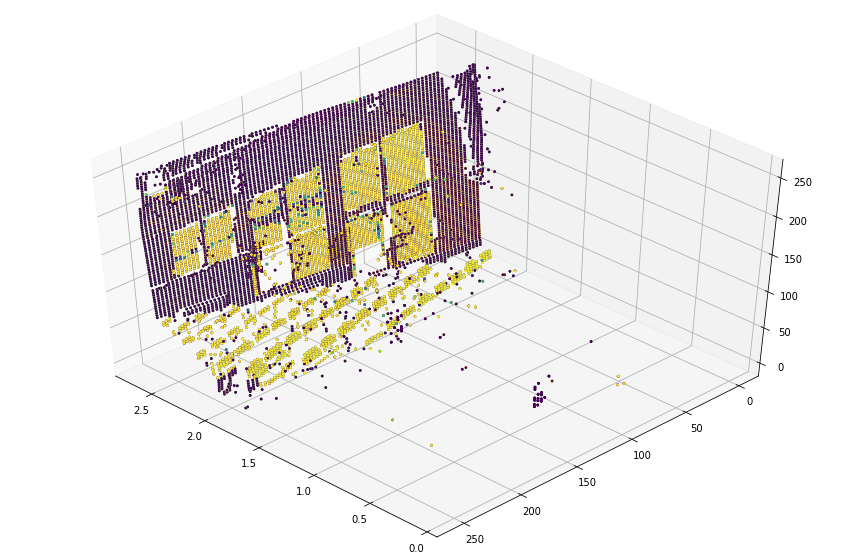

In [ ]:
depth_vis = np.flipud(visualize_samples[1][1].squeeze())  # target
img_vis = np.flipud(visualize_samples[0][1].squeeze())  # input

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")

STEP = 3
for x in range(0, img_vis.shape[0], STEP):
    for y in range(0, img_vis.shape[1], STEP):
        ax.scatter(
            [depth_vis[x, y]] * 3,
            [y] * 3,
            [x] * 3,
            c=tuple(img_vis[x, y, :3] / 255),
            s=3,
        )
    ax.view_init(45, 135)

## Building the model CNN

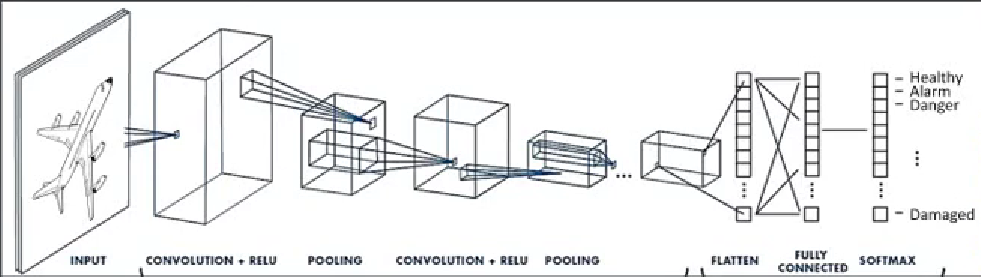

In [ ]:
from IPython.display import display, Image
display(Image(filename='/content/drive/MyDrive/Thị giác máy tính/Đồ án/cnn.PNG'))

In [ ]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)

        self.reluA = layers.LeakyReLU(alpha=0.2)

        self.bn2a = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.bn2a(x)
        p = self.pool(x)
        return p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
#        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)

        self.reluA = layers.LeakyReLU(alpha=0.2)

        self.bn2a = tf.keras.layers.BatchNormalization()

        #self.conc = layers.Concatenate()#

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.bn2a(x)
        return x




In [ ]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [50,80, 100, 120]
        self.downscale_blocks = [
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]

        self.upscale_blocks = [
            UpscaleBlock(f[0]),
            UpscaleBlock(f[0]),
            UpscaleBlock(f[0]),
            UpscaleBlock(f[3]),
        ]
        self.conv_layer = layers.Conv2D(120, (1, 1), padding="same", activation="tanh")
        
        self.conTran2d = layers.Conv2DTranspose(filters = 120, kernel_size=(3, 2), strides= 2 ,padding="same" )
        self.relu = layers.LeakyReLU(alpha=0.2)

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }
        


    def call(self, x):
        p1 = self.upscale_blocks[0](x)
        p2 = self.upscale_blocks[1](p1)
        p3 = self.upscale_blocks[2](p2)
        
        p4 = self.downscale_blocks[0](p3)
        p5 = self.downscale_blocks[1](p4)
        p6 = self.downscale_blocks[2](p5)

        p7 = self.upscale_blocks[3](p6)
        p8 = self.conTran2d(p7)
        p9 = self.relu(p8)
        p10 = self.conv_layer(p9)
        

        return p10

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=validation_loader,
)

Epoch 1/30


InvalidArgumentError: ignored

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)